In [43]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import xgboost as xgb
import optuna
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
RANDOM_STATE = 21
torch.manual_seed(21)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Collection

Considering that music preferences have changed over the years, I assumed that the decade in which the song was released was a sign worthy of attention

In [44]:
df_60 = pd.read_csv("data/dataset-of-60s.csv")
df_60['decade_of_release'] = 60
df_70 = pd.read_csv("data/dataset-of-70s.csv")
df_70['decade_of_release'] = 70
df_80 = pd.read_csv("data/dataset-of-80s.csv")
df_80['decade_of_release'] = 80
df_90 = pd.read_csv("data/dataset-of-90s.csv")
df_90['decade_of_release'] = 90
df_00 = pd.read_csv("data/dataset-of-00s.csv")
df_00['decade_of_release'] = 0
df_10 = pd.read_csv("data/dataset-of-10s.csv")
df_10['decade_of_release'] = 10
df = pd.concat([df_00, df_10, df_60, df_70, df_80, df_90])
df = df[['uri','track','artist','danceability','energy','key','loudness',
  'mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature','chorus_hit','sections','decade_of_release','target']]
df

,uri,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade_of_release,target
0,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,Lucky Man,Montgomery Gentry,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,0,1
1,spotify:track:1zyqZONW985Cs4osz9wlsu,On The Hotline,Pretty Ricky,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587,4,41.51106,10,0,1
2,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,Clouds Of Dementia,Candlemass,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893,4,65.32887,13,0,0
3,spotify:track:2IjBPp2vMeX7LggzRN3iSX,"Heavy Metal, Raise Hell!",Zwartketterij,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667,4,58.59528,9,0,0
4,spotify:track:1tF370eYXUcWwkIvaq3IGz,I Got A Feelin',Billy Currington,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760,4,22.62384,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,(You're A) Go Nowhere,Reagan Youth,0.396,0.795,9,-6.070,0,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107,4,30.34109,6,90,0
5516,spotify:track:43DFcnOZprnVlAFKwgBJ3e,La Fiebre de Norma,La Castañeda,0.621,0.655,9,-6.281,0,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653,4,34.89506,10,90,0
5517,spotify:track:6UPfnVoOq3y3BvapBIKs8J,Good Times,Edie Brickell,0.562,0.314,10,-15.213,0,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827,4,21.11763,10,90,1
5518,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,Inane,KMFDM,0.622,0.781,7,-6.080,1,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053,4,47.13558,11,90,0


# Preprocessing

Finding the number of rows and columns

In [45]:
df.shape

(41106, 20)

searching for unique artists and track names

In [46]:
print(f'Unique artists - {len(df['artist'].unique())}\nUnique track names - {len(df['track'].unique())}')

Unique artists - 11904
Unique track names - 35860


Exploring data types and checking for nulls

In [47]:
df

,uri,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade_of_release,target
0,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,Lucky Man,Montgomery Gentry,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,0,1
1,spotify:track:1zyqZONW985Cs4osz9wlsu,On The Hotline,Pretty Ricky,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587,4,41.51106,10,0,1
2,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,Clouds Of Dementia,Candlemass,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893,4,65.32887,13,0,0
3,spotify:track:2IjBPp2vMeX7LggzRN3iSX,"Heavy Metal, Raise Hell!",Zwartketterij,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667,4,58.59528,9,0,0
4,spotify:track:1tF370eYXUcWwkIvaq3IGz,I Got A Feelin',Billy Currington,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760,4,22.62384,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,(You're A) Go Nowhere,Reagan Youth,0.396,0.795,9,-6.070,0,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107,4,30.34109,6,90,0
5516,spotify:track:43DFcnOZprnVlAFKwgBJ3e,La Fiebre de Norma,La Castañeda,0.621,0.655,9,-6.281,0,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653,4,34.89506,10,90,0
5517,spotify:track:6UPfnVoOq3y3BvapBIKs8J,Good Times,Edie Brickell,0.562,0.314,10,-15.213,0,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827,4,21.11763,10,90,1
5518,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,Inane,KMFDM,0.622,0.781,7,-6.080,1,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053,4,47.13558,11,90,0


Checking for nulls again. Making doubly sure

In [48]:
df.isnull().sum()

uri                  0
track                0
artist               0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
chorus_hit           0
sections             0
decade_of_release    0
target               0
dtype: int64

We can see that there are no null values in the dataset. Taking the rough statistics of the data.

In [49]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade_of_release,target
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,52.925607,0.500000
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,32.562672,0.500006
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599792,8.000000,10.000000,0.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,60.000000,0.500000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,80.000000,1.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,90.000000,1.000000


In [50]:
df['time_signature'].describe()

count    41106.000000
mean         3.893689
std          0.423073
min          0.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64

column time signature will be droped as most values are 4.

In [51]:
#Scaling the data
scale = StandardScaler()

df_X = df.drop(axis=1, labels=['time_signature','uri','target', 'track', 'artist'])


df_scaled = scale.fit_transform(df_X)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_X.columns
df_scaled

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,chorus_hit,sections,decade_of_release
0,0.215416,-0.429668,-0.343315,0.555679,0.665030,-0.511673,0.011220,-0.508740,-0.245926,-0.039055,0.471597,-0.320853,-0.485415,0.518152,-1.625366
1,0.924004,1.086412,1.354030,0.893245,-1.503691,1.277886,-1.020031,-0.508740,-0.309525,0.544503,-0.905554,0.064804,0.073928,-0.097638,-1.625366
2,-2.124046,1.015160,1.071139,1.357892,0.665030,-0.297994,-1.074290,-0.493684,-0.159199,-0.906910,-1.112575,0.874330,1.327148,0.518152,-1.625366
3,-1.977830,1.640592,-0.343315,1.219326,0.665030,1.080465,-1.074596,-0.250443,-0.055127,-0.783465,1.000112,0.174751,0.972847,-0.302901,-1.625366
4,0.507849,0.730153,-0.909096,1.104859,0.665030,-0.527931,-0.003533,-0.508740,-0.442506,0.331280,-0.248819,-0.345625,-0.919860,-0.097638,-1.625366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,-0.808099,0.852864,1.071139,0.781602,-1.503691,1.870147,-1.071880,-0.508052,-0.112945,0.821319,1.154862,-1.284154,-0.513802,-0.918691,1.138569
41102,0.457236,0.298684,1.071139,0.741877,-1.503691,-0.488447,-0.925315,-0.488116,-0.623476,0.551984,0.509605,-0.195220,-0.274186,-0.097638,1.138569
41103,0.125437,-1.051141,1.354030,-0.939738,-1.503691,-0.501221,0.223667,-0.508704,-0.552360,0.106835,1.632688,-0.378684,-0.999112,-0.097638,1.138569
41104,0.462860,0.797446,0.505358,0.779719,0.665030,-0.419930,-1.074320,1.978688,1.049193,-1.228615,0.024494,0.800023,0.369873,0.107625,1.138569


Managing outliers and creating boxplots to analyze the distribution of data and remove outliers

Text(0.5, 1.0, 'Distribution of predictors with outliers')

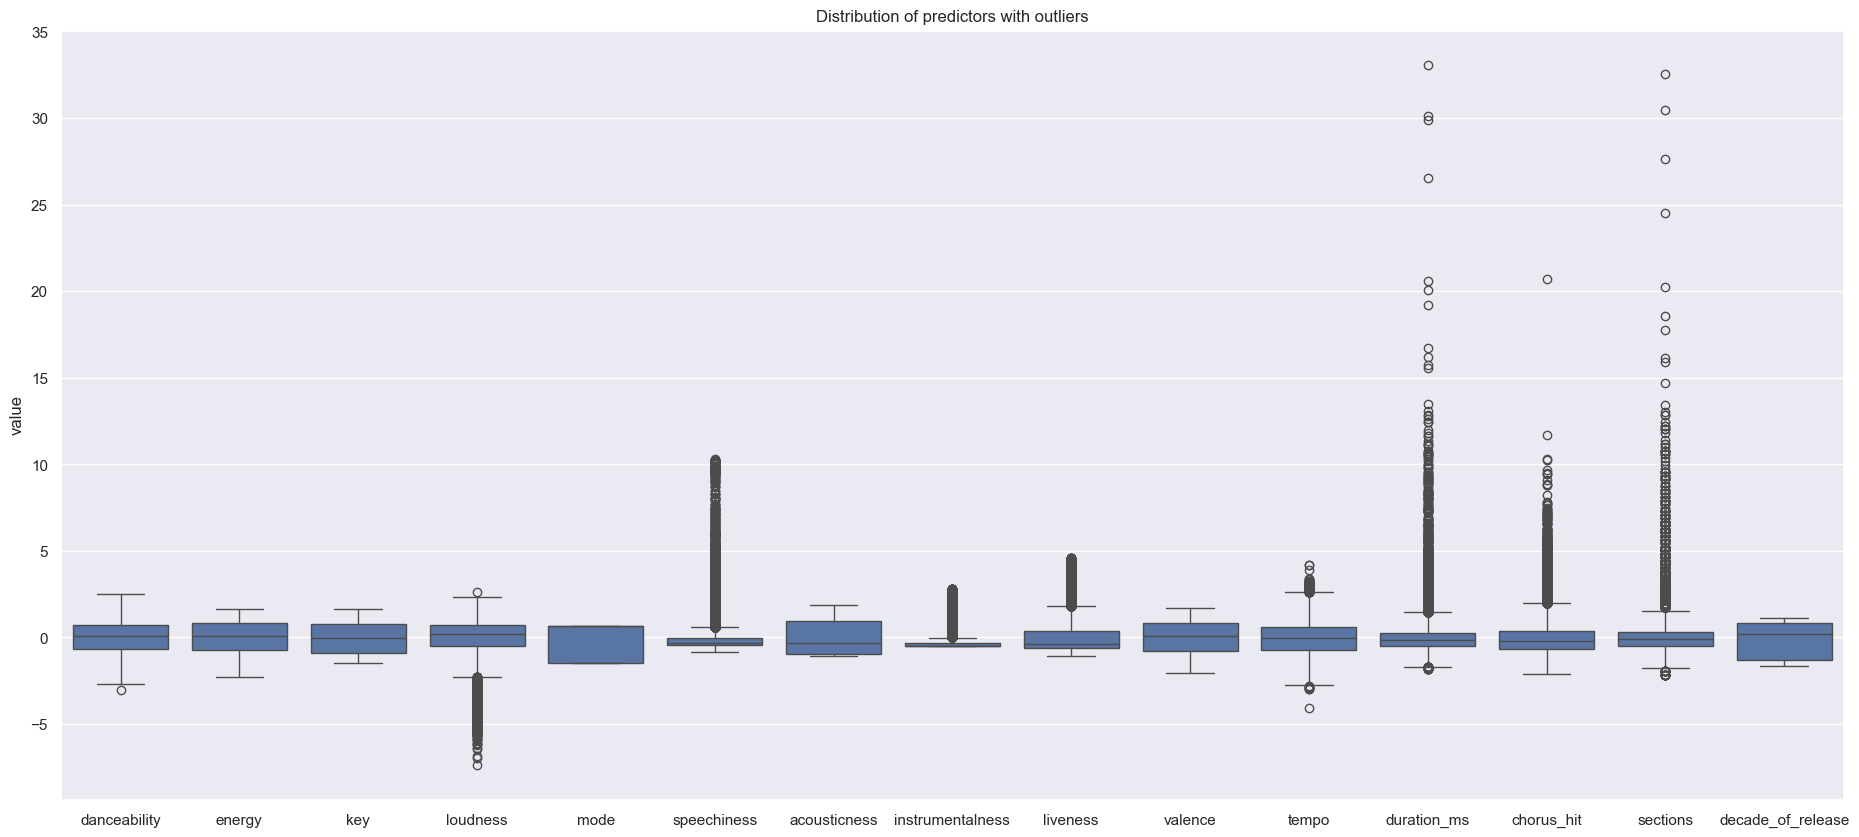

In [52]:
#box plot with outliers
df_melt=pd.melt(df_scaled)
df_melt
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt)
plt.xlabel(None)
plt.title('Distribution of predictors with outliers')

Text(0.5, 1.0, 'Distribution of predictors without outliers')

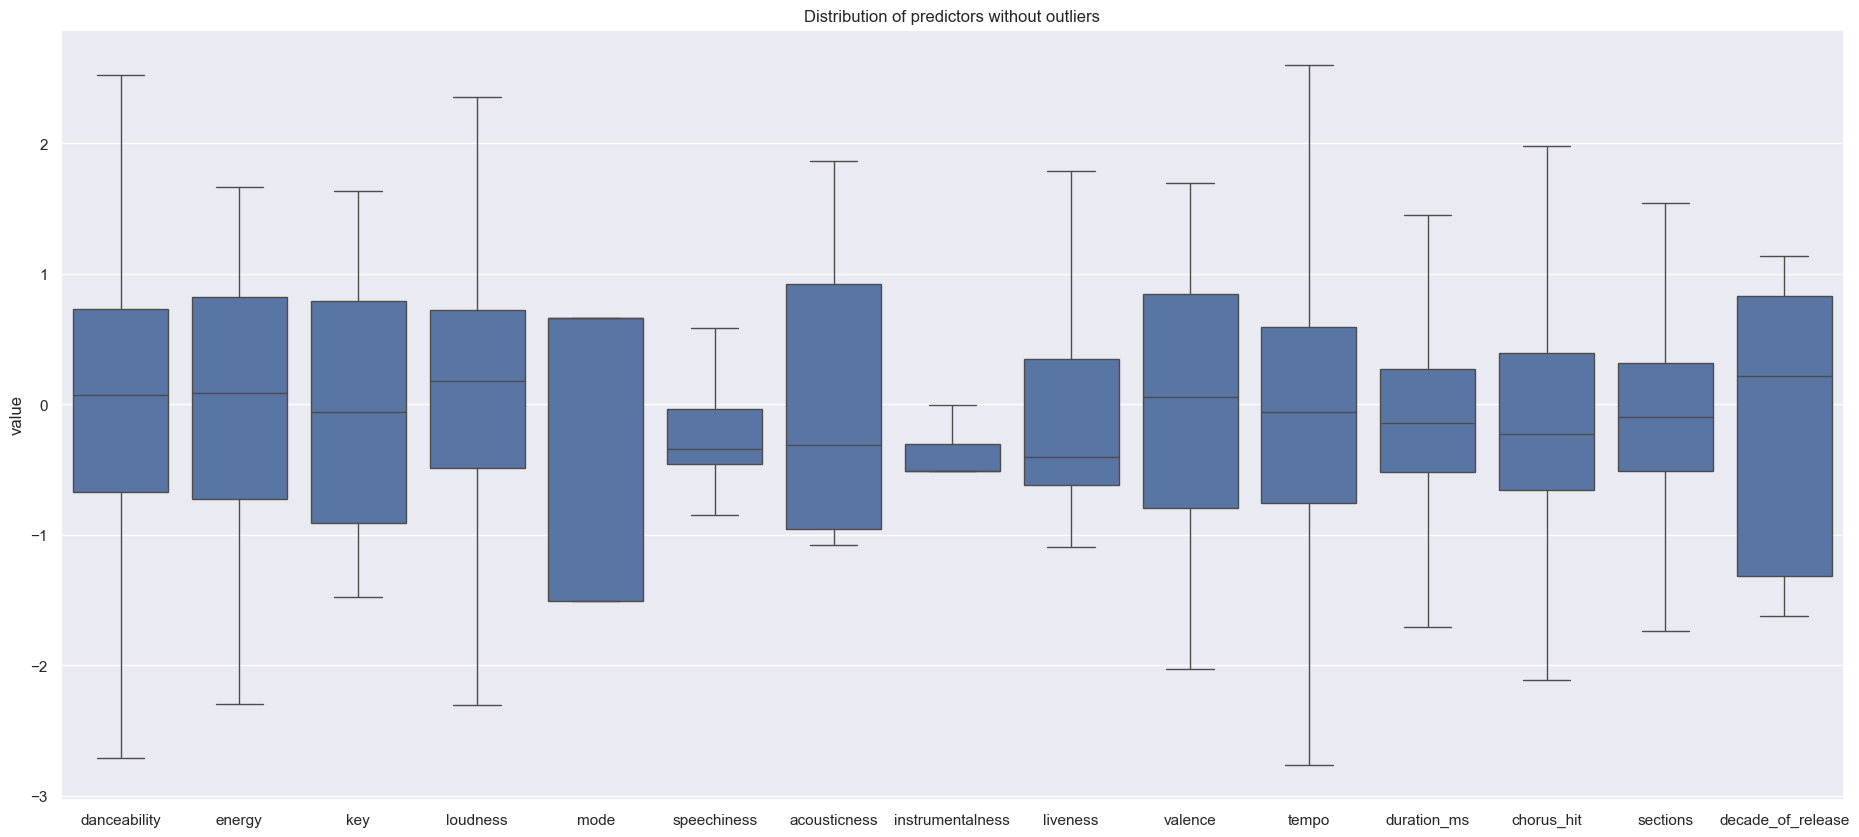

In [53]:
#boxplot without outliers
df_melt=pd.melt(df_scaled)
df_melt
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False)
plt.xlabel(None)
plt.title('Distribution of predictors without outliers')

Removing the outliers

In [54]:
df_clean = df_scaled
for col in df_clean.columns:
  q1=df_clean[col].quantile(0.25)
  q3=df_clean[col].quantile(0.75)
  inq=q3-q1
  filter=(df_clean[col] >= q1-1.5*inq) & (df_clean[col] <= q3+1.5*inq)
  df_clean[col] = df_clean[col].loc[filter]

In [55]:
#number of outliers for each predictor
df_clean.isna().sum()

danceability            1
energy                  0
key                     0
loudness             1343
mode                    0
speechiness          5088
acousticness            0
instrumentalness     8920
liveness             2688
valence                 0
tempo                 434
duration_ms          1987
chorus_hit           1839
sections             1570
decade_of_release       0
dtype: int64

Removing 2 predictors with a lot of outliers

In [56]:
#removing 2 predictors
df_clean = df_clean.drop(axis=1, labels=['speechiness', 'instrumentalness'])

In [57]:
df_remove = df_clean.dropna()
df_remove.shape

(33401, 13)

Total of 33401 songs remain after cleaning

Text(0.5, 1.0, 'Distribution of predictors without outliers')

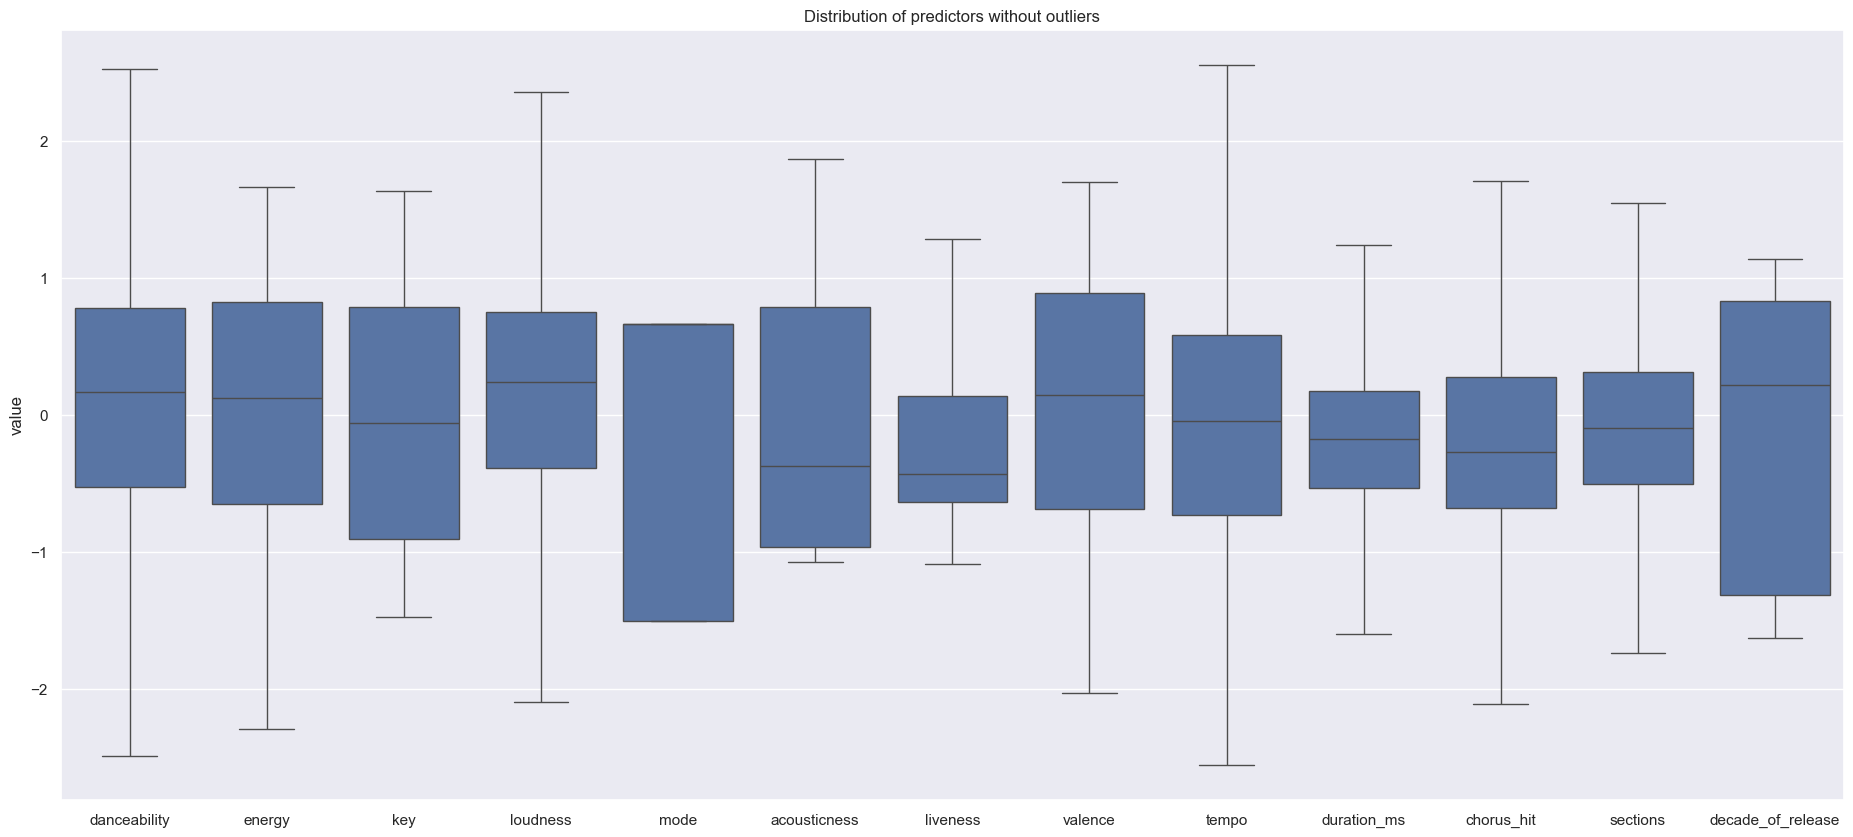

In [58]:
#box plot after removing the outliers
df_melt=pd.melt(df_remove)
df_melt
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False)
plt.xlabel(None)
plt.title('Distribution of predictors without outliers')

Creating the unscaled dataframe without the outliers

In [59]:
df_merge = df.iloc[df_remove.index]

In [60]:
df_merge = df_merge.drop(axis=1, labels=['speechiness', 'instrumentalness'])

In [61]:
df_merge.columns

Index(['uri', 'track', 'artist', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'chorus_hit', 'sections', 'decade_of_release',
       'target'],
      dtype='object')

Counting the number of observations in each class

In [62]:
#observations in each class
df_merge.groupby('target')[['danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'chorus_hit', 'sections']].count()

,danceability,energy,key,loudness,mode,acousticness,liveness,valence,tempo,duration_ms,chorus_hit,sections
target,,,,,,,,,,,,
0,15247,15247,15247,15247,15247,15247,15247,15247,15247,15247,15247,15247
1,18154,18154,18154,18154,18154,18154,18154,18154,18154,18154,18154,18154


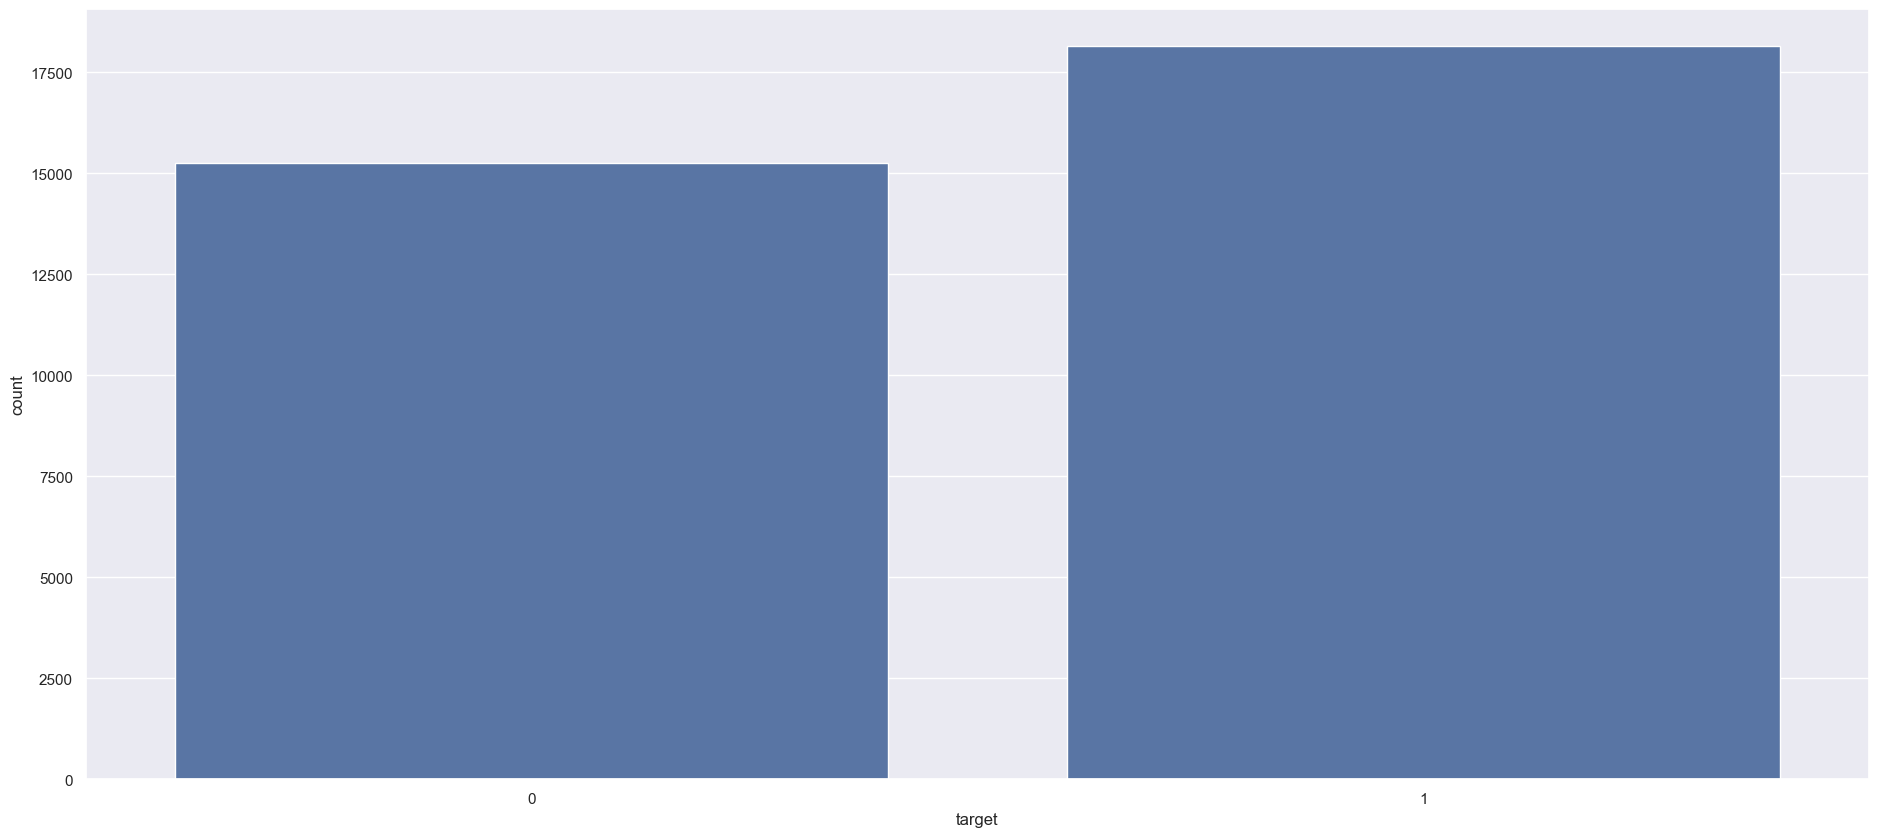

In [63]:
#plotting the number of observations
sns.countplot(x='target', data=df_merge)
sns.set_theme(rc={'figure.figsize':(12,8)})

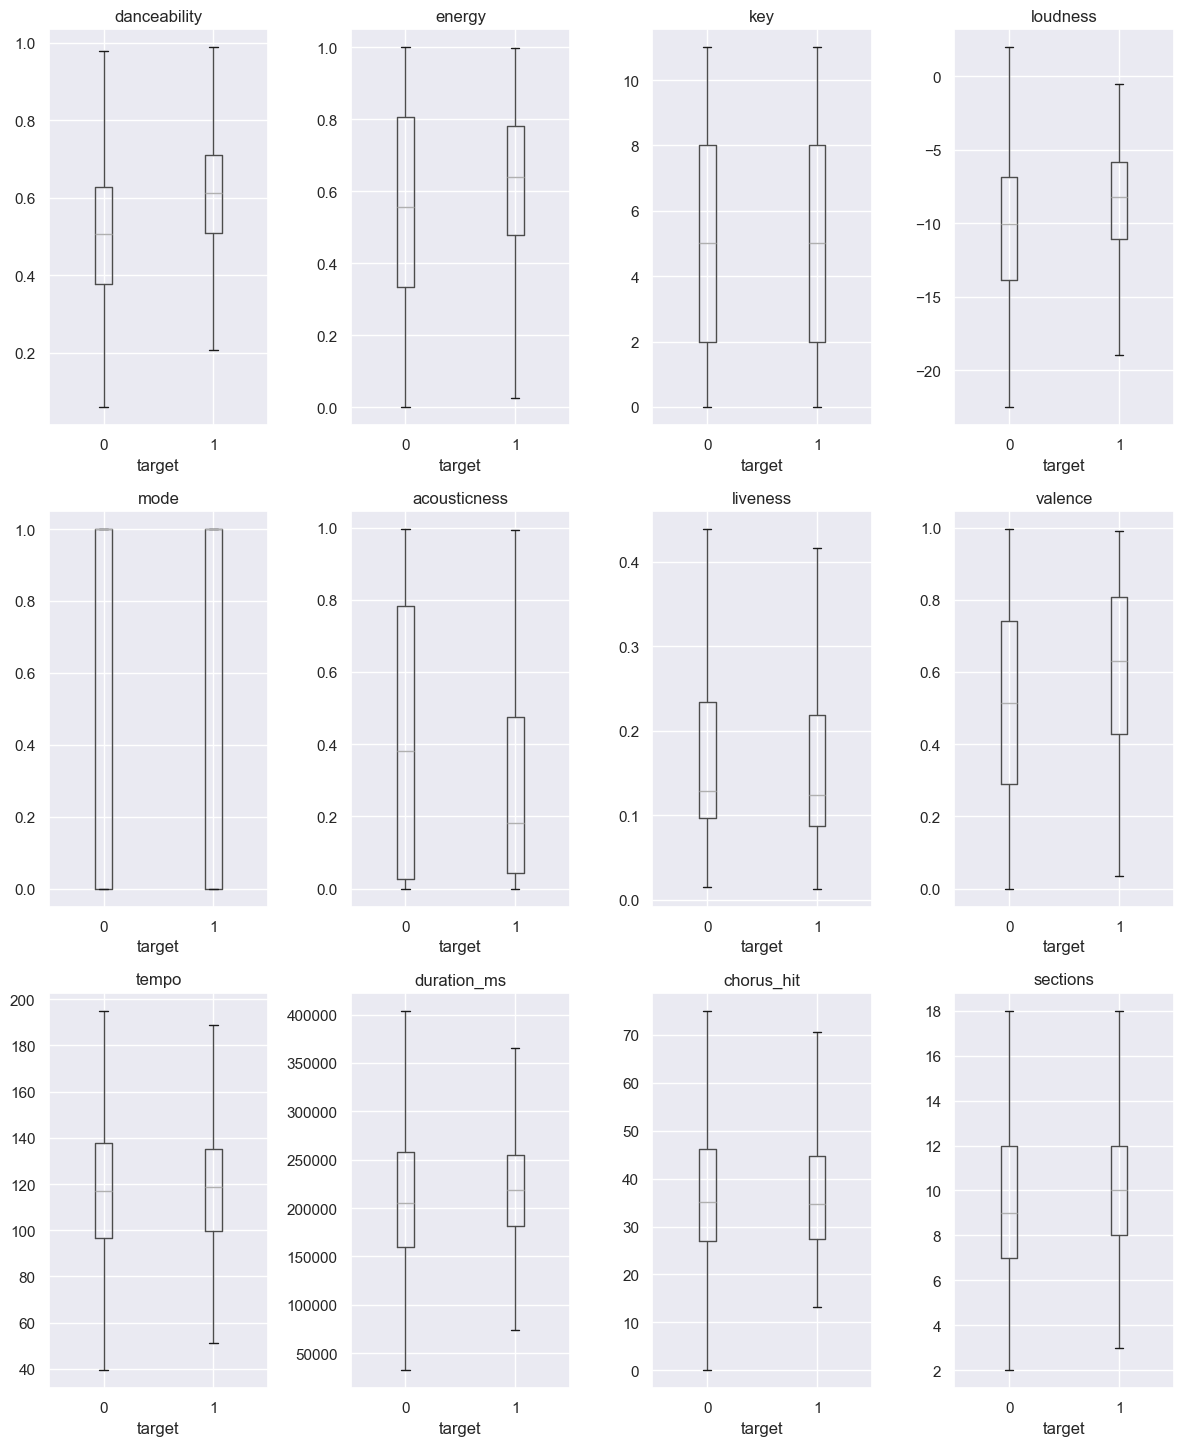

In [64]:
#plotting box plots based on target variable for different predictors
plt.rcParams["figure.figsize"] = [12, 15]
fig, axes = plt.subplots(nrows=3, ncols=4, )
df_merge.boxplot(column= 'danceability', by='target', ax=axes[0][0], showfliers=False)
df_merge.boxplot(column= 'energy', by='target', ax=axes[0][1], showfliers=False)
df_merge.boxplot(column='key', by='target', ax=axes[0][2], showfliers=False)
df_merge.boxplot(column='loudness', by='target', ax=axes[0][3], showfliers=False)
df_merge.boxplot(column='mode', by='target', ax=axes[1][0], showfliers=False)
df_merge.boxplot(column='acousticness', by='target', ax=axes[1][1], showfliers=False)
df_merge.boxplot(column='liveness', by='target', ax=axes[1][2], showfliers=False)
df_merge.boxplot(column='valence', by='target', ax=axes[1][3], showfliers=False)
df_merge.boxplot(column='tempo', by='target', ax=axes[2][0], showfliers=False)
df_merge.boxplot(column='duration_ms', by='target', ax=axes[2][1], showfliers=False)
df_merge.boxplot(column='chorus_hit', by='target', ax=axes[2][2], showfliers=False)
df_merge.boxplot(column='sections', by='target', ax=axes[2][3], showfliers=False)
plt.tight_layout()
plt.suptitle(None)
plt.show()

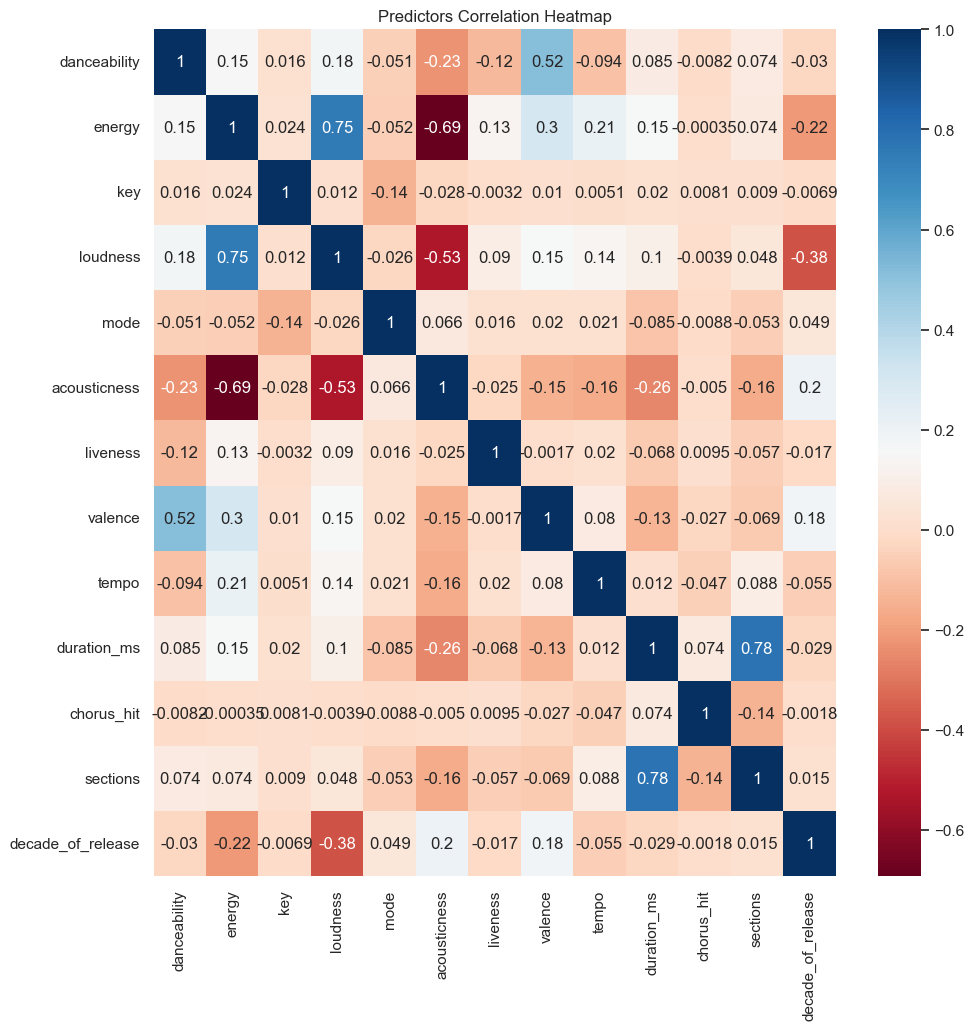

In [65]:
#correlation between the predictors
fig, ax = plt.subplots(figsize=(11,11)) 
ax = sns.heatmap(df_remove.corr(), annot=True, cmap='RdBu').set(title='Predictors Correlation Heatmap')

In [66]:
df_merge.iloc[:,3:17]

,danceability,energy,key,loudness,mode,acousticness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade_of_release
0,0.578,0.471,4,-7.270,1,0.368000,0.1590,0.532,133.061,196707,4,30.88059,13,0
1,0.704,0.854,10,-5.477,0,0.018500,0.1480,0.688,92.988,242587,4,41.51106,10,0
2,0.162,0.836,9,-3.009,1,0.000111,0.1740,0.300,86.964,338893,4,65.32887,13,0
3,0.188,0.994,4,-3.745,1,0.000007,0.1920,0.333,148.440,255667,4,58.59528,9,0
4,0.630,0.764,2,-4.353,1,0.363000,0.1250,0.631,112.098,193760,4,22.62384,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,0.396,0.795,9,-6.070,0,0.000928,0.1820,0.762,152.943,82107,4,30.34109,6,90
5516,0.621,0.655,9,-6.281,0,0.050600,0.0937,0.690,134.167,211653,4,34.89506,10,90
5517,0.562,0.314,10,-15.213,0,0.440000,0.1060,0.571,166.847,189827,4,21.11763,10,90
5518,0.622,0.781,7,-6.080,1,0.000101,0.3830,0.214,120.051,330053,4,47.13558,11,90


In [69]:
#creating final scaled data with all the variables
scale = StandardScaler()
scale_X = scale.fit_transform(df_merge.iloc[:,3:17])
df_merge.iloc[:,3:17] = scale_X

In [70]:
df_merge

,uri,track,artist,danceability,energy,key,loudness,mode,acousticness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade_of_release,target
0,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,Lucky Man,Montgomery Gentry,0.118486,-0.518795,-0.339478,0.535085,0.651748,0.072572,-0.076165,-0.126019,0.495782,-0.315094,0.237924,-0.479443,1.088622,-1.616255,1
1,spotify:track:1zyqZONW985Cs4osz9wlsu,On The Hotline,Pretty Ricky,0.861614,1.100931,1.356353,0.957657,-1.534336,-0.997974,-0.181124,0.478866,-0.953376,0.405103,0.237924,0.308361,0.031727,-1.616255,1
2,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,Clouds Of Dementia,Candlemass,-2.335015,1.024808,1.073715,1.539313,0.651748,-1.054301,0.066960,-1.025591,-1.171222,1.916857,0.237924,2.073455,1.088622,-1.616255,0
3,spotify:track:2IjBPp2vMeX7LggzRN3iSX,"Heavy Metal, Raise Hell!",Zwartketterij,-2.181672,1.692998,-0.339478,1.365853,0.651748,-1.054618,0.238710,-0.897635,1.051932,0.610425,0.237924,1.574441,-0.320571,-1.616255,0
4,spotify:track:1tF370eYXUcWwkIvaq3IGz,I Got A Feelin',Billy Currington,0.425174,0.720316,-0.904754,1.222560,0.651748,0.057257,-0.400582,0.257851,-0.262302,-0.361354,0.237924,-1.091335,0.031727,-1.616255,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,(You're A) Go Nowhere,Reagan Youth,-0.954921,0.851417,1.073715,0.817900,-1.534336,-1.051798,0.143293,0.765799,1.214773,-2.114016,0.237924,-0.519424,-1.377467,1.142766,0
5516,spotify:track:43DFcnOZprnVlAFKwgBJ3e,La Fiebre de Norma,La Castañeda,0.372093,0.259350,1.073715,0.768171,-1.534336,-0.899649,-0.699237,0.486621,0.535778,-0.080480,0.237924,-0.181938,0.031727,1.142766,0
5517,spotify:track:6UPfnVoOq3y3BvapBIKs8J,Good Times,Edie Brickell,0.024120,-1.182755,1.356353,-1.336912,-1.534336,0.293114,-0.581874,0.025203,1.717583,-0.423092,0.237924,-1.202957,0.031727,1.142766,1
5518,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,Inane,KMFDM,0.377991,0.792210,0.508438,0.815543,0.651748,-1.054332,2.061170,-1.359053,0.025302,1.778092,0.237924,0.725184,0.384025,1.142766,0


# Building the Model

Creating X and Y

In [71]:
X = df_merge.iloc[:,3:17]
X.shape

(33401, 14)

In [72]:
y = df_merge['target']
y.shape

(33401,)

**Step 1 for choosing the top models**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=RANDOM_STATE)

# First Model Training

In [74]:
#training the models
models = {
    "                   Logistic Regression": LogisticRegression(random_state=RANDOM_STATE),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Support Vector Machine (Linear Kernel)": LinearSVC(random_state=RANDOM_STATE),
    "   Support Vector Machine (RBF Kernel)": SVC(random_state=RANDOM_STATE),
    "               Neural Network(sklearn)": MLPClassifier(max_iter=500, random_state=RANDOM_STATE),
    "                         Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "            Gradient Boosting(sklearn)": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "                              Catboost": CatBoostClassifier(logging_level = 'Silent',random_state=RANDOM_STATE),
    "                               xgboost": xgb.XGBClassifier(random_state=RANDOM_STATE),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
               Neural Network(sklearn) trained.
                         Random Forest trained.
            Gradient Boosting(sklearn) trained.
                              Catboost trained.
                               xgboost trained.


In [75]:
#3-fold cross validation for choosing the top models
mean_df = []
for name, model in models.items():
  mean_arr = {}
  cv_results = cross_val_score(model, X_train, y_train, cv=3)
  mean = np.mean(cv_results)
  print(name, mean)
  mean_arr['name']=name
  mean_arr['result']=mean
  mean_df.append(mean_arr)

                   Logistic Regression 0.6826723789107451
                   K-Nearest Neighbors 0.6943489710229667
                         Decision Tree 0.6686751445703464
Support Vector Machine (Linear Kernel) 0.6832337771682404
   Support Vector Machine (RBF Kernel) 0.7570734100413458
               Neural Network(sklearn) 0.7504489694320582
                         Random Forest 0.7588321959850056
            Gradient Boosting(sklearn) 0.7499625699477647
                              Catboost 0.7712199695949057
                               xgboost 0.7565868298674933


In [76]:
pd.DataFrame(mean_df).sort_values('result',ascending=False)

,name,result
8,Catboost,0.771220
6,Random Forest,0.758832
4,Support Vector Machine (RBF Kernel),0.757073
9,xgboost,0.756587
5,Neural Network(sklearn),0.750449
7,Gradient Boosting(sklearn),0.749963
1,K-Nearest Neighbors,0.694349
3,Support Vector Machine (Linear Kernel),0.683234
0,Logistic Regression,0.682672
2,Decision Tree,0.668675


### Intermediate conclusions
1. Catboost showed the best result, it's worth continuing to work with it
2. Random forest showed a fairly good result, and it worth continuing to work with it too
3. Sklearn neural network showed good result. I should try to build torch NN for this task

# **5 fold Cross Validation for choosing the best model**

Catboost

In [77]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    catboost_model = CatBoostClassifier(**params, logging_level = 'Silent',random_state=RANDOM_STATE)
    catboost_model.fit(X_train, y_train)
    predictions = catboost_model.predict(X)
    score = accuracy_score(y, predictions)
    return score
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(objective, n_trials=30)
print(f'Best hyperparameters: {catboost_study.best_params}')
print(f'Best accuracy_score: {catboost_study.best_value}')

[I 2025-05-15 19:22:13,166] A new study created in memory with name: no-name-7c3c8bbd-47a7-41b5-868a-d329258b381f
[I 2025-05-15 19:22:20,070] Trial 0 finished with value: 0.8045866890212868 and parameters: {'learning_rate': 0.06747531969772282, 'depth': 5, 'subsample': 0.29777996492389086, 'colsample_bylevel': 0.2642278031811658, 'min_data_in_leaf': 90}. Best is trial 0 with value: 0.8045866890212868.
[I 2025-05-15 19:22:25,250] Trial 1 finished with value: 0.7086015388760816 and parameters: {'learning_rate': 0.01186066643701261, 'depth': 1, 'subsample': 0.2422327950766976, 'colsample_bylevel': 0.650907475184178, 'min_data_in_leaf': 40}. Best is trial 0 with value: 0.8045866890212868.
[I 2025-05-15 19:22:31,693] Trial 2 finished with value: 0.7170443998682674 and parameters: {'learning_rate': 0.002026675496414453, 'depth': 4, 'subsample': 0.3676251565472934, 'colsample_bylevel': 0.23096306109122067, 'min_data_in_leaf': 42}. Best is trial 0 with value: 0.8045866890212868.
[I 2025-05-15 

Best hyperparameters: {'learning_rate': 0.09960912506840036, 'depth': 10, 'subsample': 0.0636098322704924, 'colsample_bylevel': 0.4518290893766558, 'min_data_in_leaf': 56}
Best accuracy_score: 0.9531750546390827


Torch NN

In [80]:
# Transform data into pytorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

# Build datasets for model
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200)

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x, threshold=0.5):
        with torch.no_grad():
            probabilities = self.model(x)
            return (probabilities >= threshold).int()

# init
input_dim = X_train.shape[1]
model = NeuralNetwork(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Main function
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=1000, patience=10, min_delta=0.001):
    best_test_loss = float('inf')
    best_weights = None
    patience_counter = 0

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        # Test
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                test_loss += loss.item() * X_batch.size(0)
        test_loss /= len(valid_loader.dataset)

        # Progres report
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        # Early stop check
        if test_loss < best_test_loss - min_delta:
            best_test_loss = test_loss
            best_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stop on epoch {epoch+1}')
            model.load_state_dict(best_weights)
            break

    # Best weights restore
    if best_weights is not None:
        model.load_state_dict(best_weights)

    return model

# Model training
torch_model = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=10,
    min_delta=0.001
)
print(f'TorchNN accuracy_score - {accuracy_score(y_test_tensor, torch_model.predict(X_test_tensor))}')

Epoch 1/100, Train Loss: 0.6016, Test Loss: 0.5604
Epoch 2/100, Train Loss: 0.5546, Test Loss: 0.5380
Epoch 3/100, Train Loss: 0.5368, Test Loss: 0.5296
Epoch 4/100, Train Loss: 0.5254, Test Loss: 0.5171
Epoch 5/100, Train Loss: 0.5193, Test Loss: 0.5161
Epoch 6/100, Train Loss: 0.5115, Test Loss: 0.5109
Epoch 7/100, Train Loss: 0.5051, Test Loss: 0.5057
Epoch 8/100, Train Loss: 0.5021, Test Loss: 0.5028
Epoch 9/100, Train Loss: 0.4983, Test Loss: 0.5104
Epoch 10/100, Train Loss: 0.4966, Test Loss: 0.5028
Epoch 11/100, Train Loss: 0.4916, Test Loss: 0.5025
Epoch 12/100, Train Loss: 0.4918, Test Loss: 0.4991
Epoch 13/100, Train Loss: 0.4888, Test Loss: 0.4971
Epoch 14/100, Train Loss: 0.4856, Test Loss: 0.4988
Epoch 15/100, Train Loss: 0.4853, Test Loss: 0.4933
Epoch 16/100, Train Loss: 0.4818, Test Loss: 0.4955
Epoch 17/100, Train Loss: 0.4792, Test Loss: 0.4949
Epoch 18/100, Train Loss: 0.4797, Test Loss: 0.4939
Epoch 19/100, Train Loss: 0.4771, Test Loss: 0.4949
Epoch 20/100, Train L

**Random Forest**

In [81]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=1000, step=100),
        "max_depth": trial.suggest_int(name="max_depth", low=10, high=110, step=20),
        "min_samples_split": trial.suggest_int(name="min_samples_split", low=2, high=10, step=2),
        "min_samples_leaf": trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)
    }
    forest_model = RandomForestClassifier(random_state=RANDOM_STATE, **params)
    forest_model.fit(X_train, y_train)
    predictions = forest_model.predict(X)
    score = accuracy_score(y, predictions)
    return score
forest_study = optuna.create_study(direction='maximize')
forest_study.optimize(objective, n_trials=15)
print(f'Best hyperparameters: {forest_study.best_params}')
print(f'Best accuracy_score: {forest_study.best_value}')

[I 2025-05-15 19:35:18,282] A new study created in memory with name: no-name-a07025d4-5f04-4c4a-9fbf-f4a6d1d01721
[I 2025-05-15 19:35:38,331] Trial 0 finished with value: 0.775515703122661 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.775515703122661.
[I 2025-05-15 19:36:13,040] Trial 1 finished with value: 0.7702763390317655 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.775515703122661.
[I 2025-05-15 19:37:29,352] Trial 2 finished with value: 0.9125774677404868 and parameters: {'n_estimators': 1000, 'max_depth': 110, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9125774677404868.
[I 2025-05-15 19:37:33,015] Trial 3 finished with value: 0.7721026316577349 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 2 with val

Best hyperparameters: {'n_estimators': 800, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 2}
Best accuracy_score: 0.9502709499715577


Model accuracy:
catboost - 0.9551
torchNN - 0.7314
random forest - 0.9555

Now I want to find out how long it takes to predict each model.

In [82]:
catboost_model = CatBoostClassifier(learning_rate = 0.0919303008052951, depth = 10, subsample= 0.6404603346950104, colsample_bylevel = 0.5473224580358477, min_data_in_leaf = 48, logging_level = 'Silent', random_state = RANDOM_STATE)
catboost_model.fit(X_train, y_train)
start_time = time.time()
catboost_predict = catboost_model.predict(X_test)
print(f'Catboost prediction time: {time.time() - start_time}')
start_time = time.time()
torch_predict = torch_model.predict(X_test_tensor)
print(f'TorchNN prediction time: {time.time() - start_time}')
forest_model = RandomForestClassifier(n_estimators = 1000, max_depth = 50, min_samples_split = 2, min_samples_leaf = 1, random_state = RANDOM_STATE)
forest_model.fit(X_train, y_train)
start_time = time.time()
forest_predict = forest_model.predict(X_test)
print(f'Random forest prediction time: {time.time() - start_time}')

Catboost prediction time: 0.013962745666503906
TorchNN prediction time: 0.006240129470825195
Random forest prediction time: 0.9961247444152832


Random forest shows a very small increase in accuracy, but it takes 5 times longer to predict compared to catboost.
We choose catboost as our final model.

# **Catboost interpritation**

**Importance of the variables**

In [83]:
feature_importance = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: danceability, Importance: 9.22
Feature: energy, Importance: 8.24
Feature: key, Importance: 6.18
Feature: loudness, Importance: 8.86
Feature: mode, Importance: 2.45
Feature: acousticness, Importance: 9.82
Feature: liveness, Importance: 7.35
Feature: valence, Importance: 8.87
Feature: tempo, Importance: 8.09
Feature: duration_ms, Importance: 9.87
Feature: time_signature, Importance: 0.85
Feature: chorus_hit, Importance: 7.61
Feature: sections, Importance: 4.54
Feature: decade_of_release, Importance: 8.06


Text(0.5, 0, 'Feature Importance')

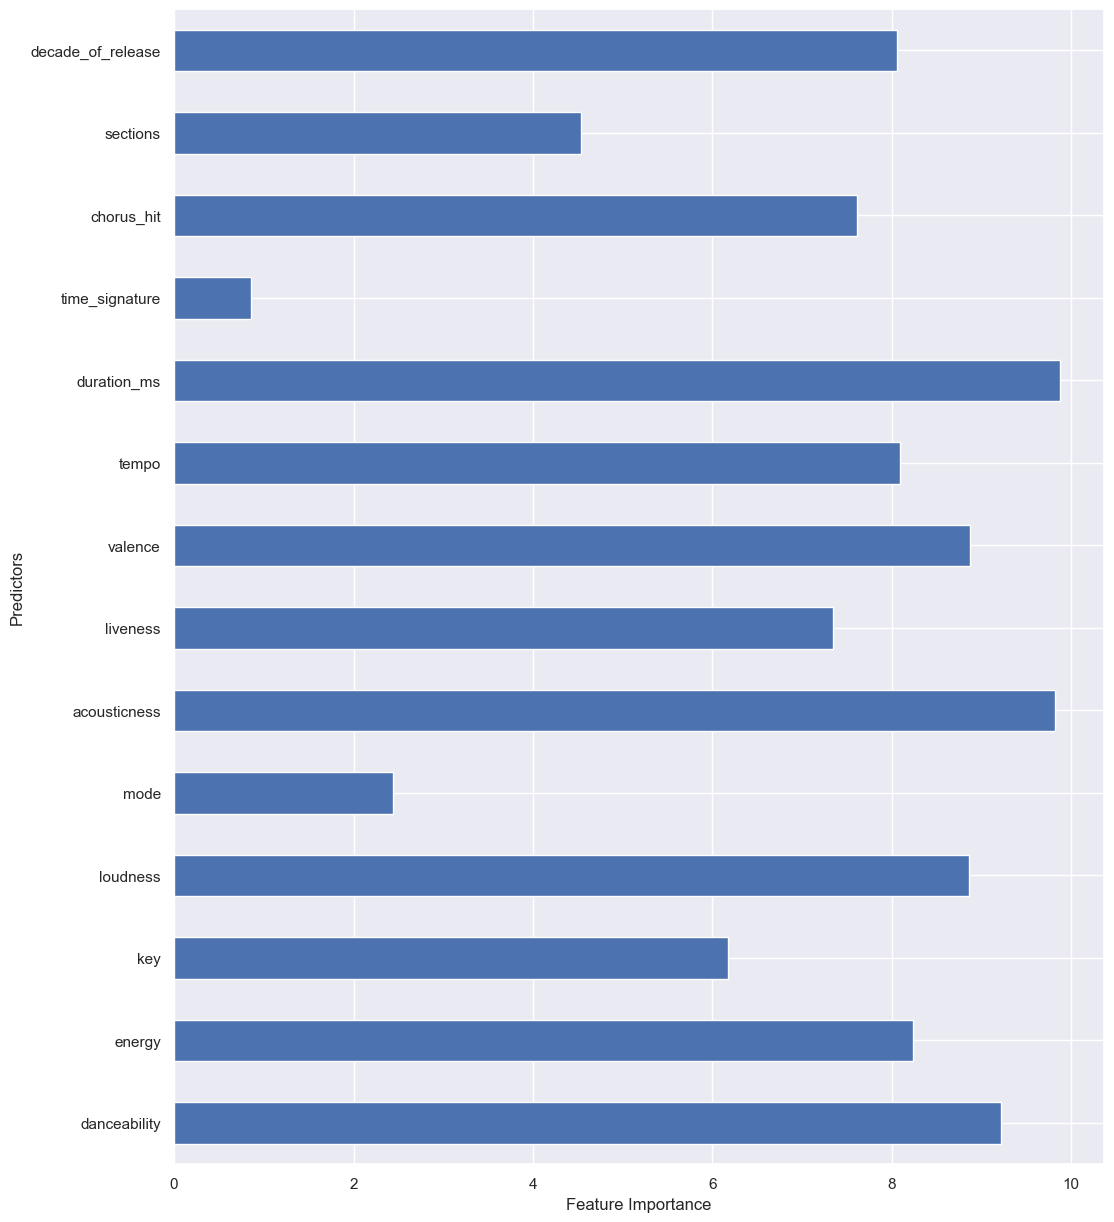

In [84]:
#plotting feature importance
feat_importance_plot = pd.Series(feature_importance, index=X.columns)
feat_importance_plot.plot(kind='barh')
plt.ylabel("Predictors")
plt.xlabel("Feature Importance")

# Performance Evaluation and Interpretation

Calculating scores

In [85]:
cb_accuracy = accuracy_score(y_test, catboost_predict)
cb_f1 = f1_score(y_test, catboost_predict)
cb_roc_auc = roc_auc_score(y_test, catboost_predict)
print(f'accuracy: {cb_accuracy:.2f}\n f1 score: {cb_f1:.2f}\n auc: {cb_roc_auc:.2f}')

accuracy: 0.77
 f1 score: 0.80
 auc: 0.77


View Confusion Matrix for test data and the predictions

In [86]:
confusion_matrix(y_test, catboost_predict, labels=[1, 0])

array([[3062,  536],
       [ 983, 2100]], dtype=int64)

Printing the classification report for test data and the predictions

In [87]:
print(classification_report(y_test, catboost_predict))

              precision    recall  f1-score   support

           0       0.80      0.68      0.73      3083
           1       0.76      0.85      0.80      3598

    accuracy                           0.77      6681
   macro avg       0.78      0.77      0.77      6681
weighted avg       0.78      0.77      0.77      6681



In [91]:
y_prob= catboost_model.predict_proba(X_test)

In [92]:
prob_1 = y_prob[::,1]

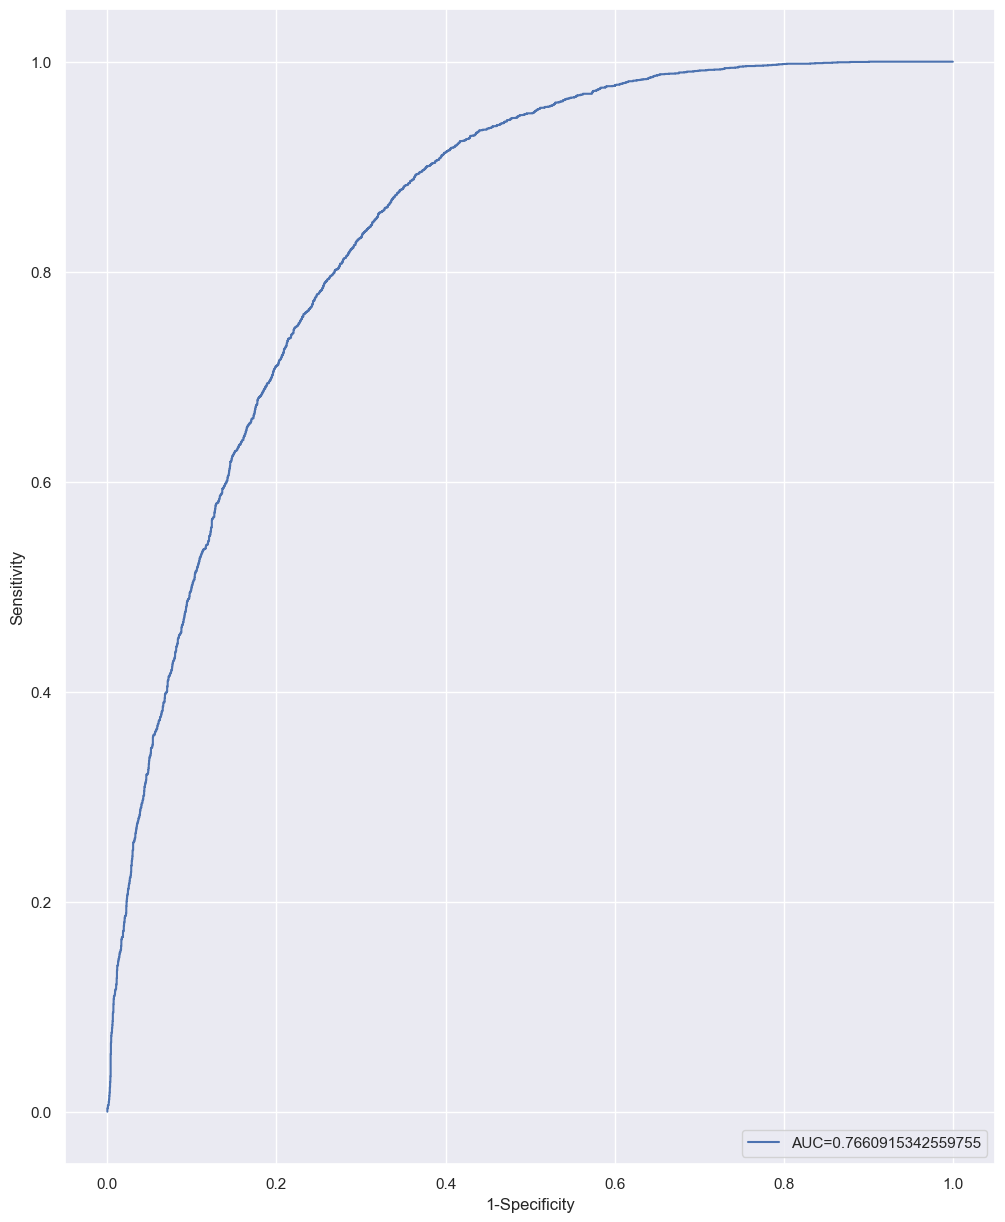

In [93]:
fpr, tpr, _ = roc_curve(y_test,  prob_1)

#create ROC curve
plt.plot(fpr,tpr, label="AUC="+str(cb_roc_auc))
plt.ylabel('Sensitivity')
plt.xlabel('1-Specificity')
plt.legend(loc=4)
plt.show()
